In [1]:
import numpy as np # numbers and algebra in python
import pandas as pd # tables and processing tabular data


In [2]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor, KerasClassifier


In [3]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [4]:
dirPath = './archive/CMaps/'

train = pd.read_csv(dirPath + 'train_FD001.txt',sep='\s+',names=col_names)
test = pd.read_csv(dirPath + 'test_FD001.txt',sep='\s+',names=col_names)
y_test = pd.read_csv(dirPath + 'RUL_FD001.txt',sep='\s+',header=None)

In [5]:
train[index_names].groupby('unit_number').max().describe()

,time_cycles
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


In [6]:
def gate_the_RUL(train,cap=150):
    # Rectifier
    train['RUL'] = np.minimum(train['RUL'],cap)
    return train

def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score,roc_auc_score
# we could have a nice function for summarising a range of common classification stats
def binary_classification_performance(y_test, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_pred = y_pred, y_true = y_test),2)
    precision = round(precision_score(y_pred = y_pred, y_true = y_test),2)
    recall = round(recall_score(y_pred = y_pred, y_true = y_test),2)
    f1_score = round(2*precision*recall/(precision + recall),2)
    specificity = round(tn/(tn+fp),2)
    npv = round(tn/(tn+fn),2)
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),2)


    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'AUC_ROC' : [auc_roc],
                         'Specificty (or TNR)': [specificity],
                         'NPV' : [npv],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]})
    return result

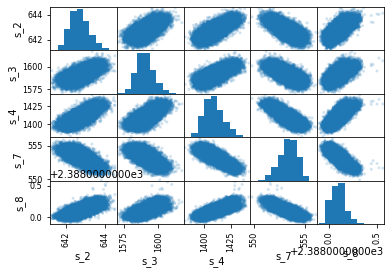

In [7]:
# Here are a small selection of useful looking signals, along with our taregt (RUL)
good_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8']
pd.plotting.scatter_matrix(train.loc[:,good_sensors], alpha=0.2)
plt.show()

As we discussed last week, we can gate the RUL during training if we "don't care about it above a threshold".
Consider histograms later in this script to understand why

In [8]:
train = add_remaining_useful_life(train)
train = gate_the_RUL(train,cap=150)

train[index_names+['RUL']] # last thing in cell prints out

,unit_number,time_cycles,RUL
0,1,1,150
1,1,2,150
2,1,3,150
3,1,4,150
4,1,5,150
...,...,...,...
20626,100,196,4
20627,100,197,3
20628,100,198,2
20629,100,199,1


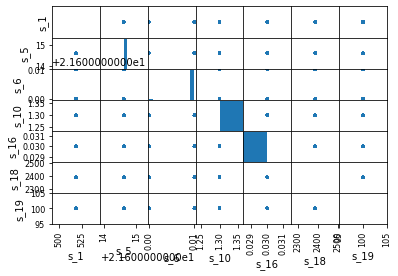

In [9]:
# these seem not worth keeping
import warnings
warnings.filterwarnings("ignore")

drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19'] # new bad signals noted. 

pd.plotting.scatter_matrix(train.loc[:,drop_sensors])
plt.show()

In [10]:
# this time let's keep the cycles (normalised) showing current engine life
drop_labels = setting_names+drop_sensors # ['unit_number'] was index_names
 # last time we dropped ['unit_number'] here

In [11]:
X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

In [12]:
X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)

In [13]:
X_test

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,31,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552
1,2,49,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618
2,3,126,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740
3,4,106,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581
4,5,98,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,642.30,1590.88,1397.94,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,8.4110,391,38.96,23.4606
96,97,134,642.59,1582.96,1410.92,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,8.4500,395,38.61,23.2953
97,98,121,642.68,1599.51,1415.47,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,8.4235,394,38.76,23.3608
98,99,97,642.00,1585.03,1397.98,554.75,2388.01,9067.16,47.26,521.82,2388.02,8150.38,8.4003,391,38.95,23.3595


In [14]:
f = lambda x: x.rolling(5,min_periods=0).mean() 
X_train = X_train.groupby('unit_number').apply(f)
X_train

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1.0,1.0,641.820000,1589.700000,1400.600000,554.360000,2388.0600,9046.190000,47.470,521.660,2388.020,8138.620000,8.419500,392.000000,39.060000,23.419000
1,1.0,1.5,641.985000,1590.760000,1401.870000,554.055000,2388.0500,9045.130000,47.480,521.970,2388.045,8135.055000,8.425650,392.000000,39.030000,23.421300
2,1.0,2.0,642.106667,1589.836667,1402.646667,554.123333,2388.0600,9047.733333,47.410,522.120,2388.040,8134.446667,8.423033,391.333333,39.003333,23.395600
3,1.0,2.5,642.167500,1588.075000,1402.452500,554.205000,2388.0725,9048.170000,47.340,522.305,2388.050,8134.292500,8.409325,391.500000,38.972500,23.390175
4,1.0,3.0,642.208000,1587.030000,1403.206000,554.164000,2388.0700,9049.566000,47.328,522.282,2388.048,8134.194000,8.413340,391.800000,38.958000,23.393020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100.0,194.0,643.448000,1599.270000,1427.270000,551.604000,2388.2220,9066.416000,48.156,519.890,2388.232,8141.130000,8.520120,395.800000,38.408000,23.079640
20627,100.0,195.0,643.450000,1599.924000,1430.090000,551.548000,2388.2340,9067.348000,48.128,519.708,2388.234,8139.738000,8.525060,395.400000,38.356000,23.096120
20628,100.0,196.0,643.516000,1600.454000,1429.940000,551.328000,2388.2240,9067.014000,48.108,519.688,2388.244,8139.544000,8.529500,395.600000,38.350000,23.078180
20629,100.0,197.0,643.418000,1602.048000,1429.764000,551.066000,2388.2280,9067.988000,48.162,519.712,2388.246,8139.468000,8.532980,395.800000,38.332000,23.064500


In [15]:
# zero-centered normalise (standardise or zscore)
mu = np.mean(X_train,axis=0)
sig = np.std(X_train,axis=0)
X_train = (X_train - mu) / sig
X_test = (X_test - mu) / sig

In [16]:
np.std(X_train,axis=0)

unit_number    1.0
time_cycles    1.0
s_2            1.0
s_3            1.0
s_4            1.0
s_7            1.0
s_8            1.0
s_9            1.0
s_11           1.0
s_12           1.0
s_13           1.0
s_14           1.0
s_15           1.0
s_17           1.0
s_20           1.0
s_21           1.0
dtype: float64

In [17]:
from sklearn.decomposition import PCA
reduce_dim = 8

pca = PCA(n_components=reduce_dim)
pca.fit(X_train)

print(pca.explained_variance_ratio_)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

[0.71769606 0.14115369 0.06274844 0.0264292  0.00828486 0.00713111
 0.00656403 0.0053098 ]


In [18]:
img_rows, img_cols = 1, reduce_dim
input_shape = (img_rows, img_cols, 1)

In [19]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
# X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# X_val = X_val.astype('float32')

In [20]:
model = tf.keras.models.Sequential()

In [21]:
X_train.shape

(20631, 1, 8, 1)

In [22]:
f = lambda y: y<=30

y_train = y_train.apply(f)
y_test = y_test.apply(f)
y_test = np.squeeze(y_test)

In [23]:
num_classes = len(np.unique(y_train))
num_classes

2

In [24]:
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [25]:
model.add(tf.keras.layers.Conv2D(32, kernel_size=(1, 5),padding='same',               
                 input_shape=input_shape))
model.add(tf.keras.layers.BatchNormalization()) # bnorm
model.add(tf.keras.layers.Activation("relu"))
model.add(
        tf.keras.layers.Conv2D(
            filters=64, kernel_size=(1,3), strides=(1),name="c2",padding='same',
        ),)
model.add(tf.keras.layers.BatchNormalization()) # bnorm
model.add(tf.keras.layers.Activation("relu"))
model.add(
        tf.keras.layers.Conv2D(
            filters=128, kernel_size=(1,3), strides=(1),name="c3",padding='same',
        ),)

model.add(tf.keras.layers.BatchNormalization()) # bnorm
model.add(tf.keras.layers.Activation("relu"))

model.add(
        tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1,3), strides=(1),name="c4",padding='same',
        ),)
model.add(tf.keras.layers.BatchNormalization()) # bnorm
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(num_classes, activation="softmax")) 

In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005) # default is 0.001
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


In [27]:
# note we could have said validation_split,0.2. We can set shuffle here too... shuffle=True,
history = model.fit(X_train, y_train, batch_size = 128, epochs = 30, verbose=1, 
                   callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=1,
                                                     verbose=0, mode='min')],
                  validation_split=0.2)


Epoch 1/30
129/129 [==============================] - 2s 12ms/step - loss: 0.1316 - accuracy: 0.9538 - val_loss: 0.3206 - val_accuracy: 0.8662
Epoch 2/30
129/129 [==============================] - 1s 9ms/step - loss: 0.0811 - accuracy: 0.9660 - val_loss: 0.1681 - val_accuracy: 0.9326
Epoch 3/30
129/129 [==============================] - 1s 9ms/step - loss: 0.0703 - accuracy: 0.9713 - val_loss: 0.1060 - val_accuracy: 0.9557
Epoch 4/30
129/129 [==============================] - 1s 9ms/step - loss: 0.0658 - accuracy: 0.9730 - val_loss: 0.1443 - val_accuracy: 0.9513


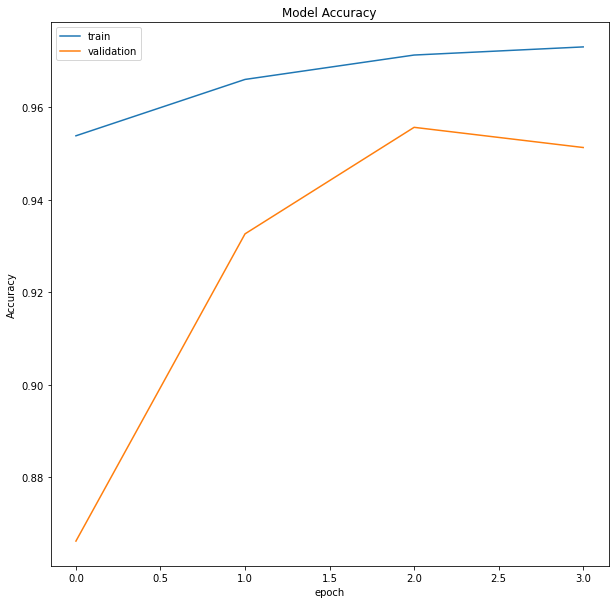

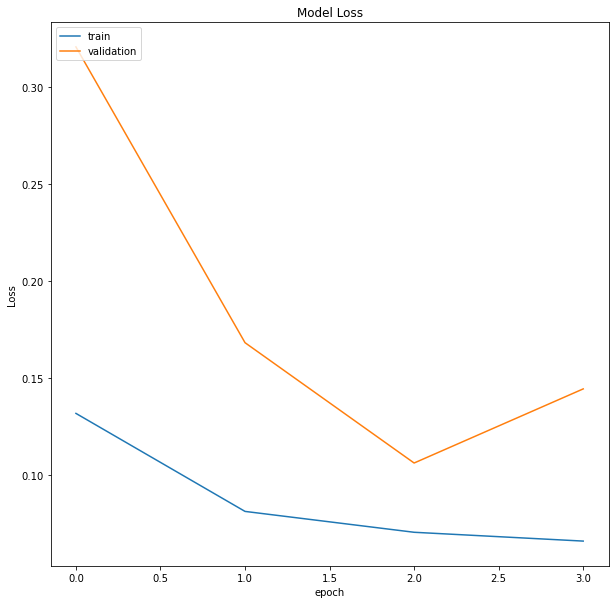

In [28]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracyCNN.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left') 
plt.show()
fig_acc.savefig("model_classification_loss.png")

In [29]:
model_pred = model.predict(X_test)

4/4 [==============================] - 0s 2ms/step


In [30]:
y_test.shape

(100, 2)

In [31]:
model_pred.shape

(100, 2)

array([[75,  0],
       [ 6, 19]], dtype=int64)

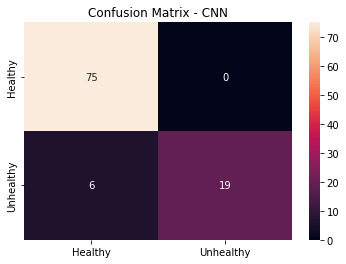

In [32]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

y_classT = np.argmax(y_test,axis=1)
y_classP = np.argmax(model_pred,axis=1)
cm = confusion_matrix(y_classT, y_classP)
cmplot = sns.heatmap(cm,annot=True,xticklabels=["Healthy","Unhealthy"],yticklabels=["Healthy","Unhealthy"] )
cmplot.set_title("Confusion Matrix - CNN" )

cm

In [33]:
accu = np.mean( y_classT == y_classP)
accu

0.94

In [34]:
cohen_kappa_score(y_classT, y_classP)

0.8260869565217391

In [35]:
binary_classification_performance(y_classT, y_classP)

,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.94,1.0,0.76,0.86,0.88,1.0,0.76,75,19,0,6


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 8, 32)          192       
                                                                 
 batch_normalization (BatchN  (None, 1, 8, 32)         128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1, 8, 32)          0         
                                                                 
 c2 (Conv2D)                 (None, 1, 8, 64)          6208      
                                                                 
 batch_normalization_1 (Batc  (None, 1, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 1, 8, 64)          0

In [37]:
# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [10, 15, 20]
learn_rate = [0.001, 0.005, 0.01]
momentum = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
# param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum, batch_size=batch_size, epochs=epochs)
param_grid = dict(optimizer__learning_rate=learn_rate)


In [38]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

model2 = KerasClassifier(build_fn=model, epochs=10, batch_size=128, verbose=0)
grid = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')

grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpab8mv806\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpab8mv806\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpc31_xhc3\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpc31_xhc3\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmphy37io2o\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmphy37io2o\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmp_pdt05x0\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmp_pdt05x0\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpp34hw0qc\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpp34hw0qc\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpvc8hqmg7\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpvc8hqmg7\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpktqlu0br\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpktqlu0br\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmp6r592gi9\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmp6r592gi9\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmp587sxroc\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmp587sxroc\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpu54r6w2o\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpu54r6w2o\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpma_ugr5r\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpma_ugr5r\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpwij_ok3g\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpwij_ok3g\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmp4wkrxv7j\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmp4wkrxv7j\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmp2af6rl45\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmp2af6rl45\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpm_4aqubg\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpm_4aqubg\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmp_f8r8tvg\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmp_f8r8tvg\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpfqkk1etc\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpfqkk1etc\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpwx4ixl3l\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpwx4ixl3l\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpwua2nd55\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpwua2nd55\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpbalbr2oa\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpbalbr2oa\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpd_7cl9ar\assets


INFO:tensorflow:Assets written to: C:\Users\stuar\AppData\Local\Temp\tmpd_7cl9ar\assets


Best: -0.048568 using {'optimizer__learning_rate': 0.005}
-0.051234 (0.011779) with: {'optimizer__learning_rate': 0.001}
-0.048568 (0.017091) with: {'optimizer__learning_rate': 0.005}
-0.049052 (0.010567) with: {'optimizer__learning_rate': 0.01}


In [39]:
model_gs = grid.best_estimator_
model_pred = model_gs.predict(X_test)

Text(0.5, 1.0, 'Confusion Matrix - CNN')

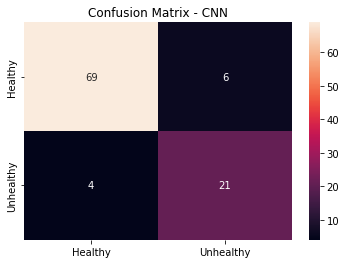

In [40]:
y_classT = np.argmax(y_test,axis=1)
y_classP = np.argmax(model_pred,axis=1)
cm = confusion_matrix(y_classT, y_classP)
cmplot = sns.heatmap(cm,annot=True,xticklabels=["Healthy","Unhealthy"],yticklabels=["Healthy","Unhealthy"] )
cmplot.set_title("Confusion Matrix - CNN" )

In [41]:
accu = np.mean( y_classT == y_classP)
accu

0.9

In [42]:
cohen_kappa_score(y_classT, y_classP)

0.7402597402597403

In [43]:
binary_classification_performance(y_classT, y_classP)

,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.9,0.78,0.84,0.81,0.88,0.78,0.84,69,21,6,4


In [44]:
model.save('cnn_classifier_nasa.tf')

INFO:tensorflow:Assets written to: cnn_classifier_nasa.tf\assets


INFO:tensorflow:Assets written to: cnn_classifier_nasa.tf\assets


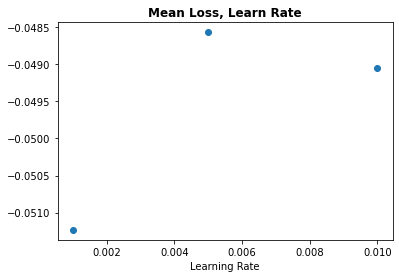

In [45]:
plt.scatter(learn_rate,means)
  
plt.title("Mean Loss, Learn Rate", fontweight ="bold")
plt.xlabel("Learning Rate")
plt.show()

In [46]:
params

[{'optimizer__learning_rate': 0.001},
 {'optimizer__learning_rate': 0.005},
 {'optimizer__learning_rate': 0.01}]

In [47]:
means

array([-0.05123358, -0.04856769, -0.0490524 ])